<a href="https://colab.research.google.com/github/aashrithresearch/pytorch_pathology/blob/main/lymphoma_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataname="lymphoma"
gpuid=0

In [ ]:
num_classes = 3
in_channels = 3

In [ ]:
growth_rate = 32 #controls num features added by Dense Block
block_config = (2, 2, 2, 2) #num layers in each Dense Block
num_init_features = 64 #num initial features
bn_size = 4 #bottleneck size, controls reduction factor
drop_rate = 0 #dropout rate

In [ ]:
batch_size = 128
patch_size = 224
num_epochs = 100
phases = ["train", "val"]
validation_phases = ["val"]

In [ ]:
! pip install tensorboardX -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.4 MB/s eta 0:00:00


In [ ]:
! pip install albumentations==0.4.6 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.models import DenseNet

from albumentations import *
from albumentations.pytorch import ToTensor


import PIL
import matplotlib.pyplot as plt
import cv2

import numpy as np
import sys, glob

from tensorboardX import SummaryWriter

import time
import math
import tables

import random

from sklearn.metrics import confusion_matrix

In [ ]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent+.00001)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
print(torch.cuda.get_device_properties(gpuid))
torch.cuda.set_device(gpuid)
device = torch.device(f'cuda:{gpuid}' if torch.cuda.is_available() else 'cpu')

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15095MB, multi_processor_count=40, uuid=146c6f9a-2a80-30e4-d7be-0a410fae9d80, L2_cache_size=4MB)


In [ ]:
model = DenseNet(growth_rate=growth_rate, block_config=block_config,
                 num_init_features=num_init_features,
                 bn_size=bn_size,
                 drop_rate=drop_rate,
                 num_classes=num_classes).to(device)

In [ ]:
print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")

total params: 	415683


In [ ]:
class Dataset(object):
    def __init__(self, fname ,img_transform=None):
        self.fname=fname

        self.img_transform=img_transform

        with tables.open_file(self.fname,'r') as db:
            self.classsizes=db.root.classsizes[:]
            self.nitems=db.root.imgs.shape[0]

        self.imgs = None
        self.labels = None

    def __getitem__(self, index):
        with tables.open_file(self.fname,'r') as db:
            self.imgs=db.root.imgs
            self.labels=db.root.labels

            img = self.imgs[index,:,:,:]
            label = self.labels[index]


        img_new = img

        if self.img_transform:
            img_new = self.img_transform(image=img)['image']

        return img_new, label, img
    def __len__(self):
        return self.nitems

In [ ]:
img_transform = Compose([
       VerticalFlip(p=.5),
       HorizontalFlip(p=.5),
       HueSaturationValue(hue_shift_limit=(-25,0),sat_shift_limit=0,val_shift_limit=0,p=1),
       Rotate(p=1, border_mode=cv2.BORDER_CONSTANT,value=0),
       RandomSizedCrop((patch_size,patch_size), patch_size,patch_size),
       ToTensor()
    ])

In [ ]:
dataset={}
dataLoader={}
for phase in phases:
    dataset[phase]=Dataset(f"/content/drive/MyDrive/lymphoma.tar/{dataname}_{phase}.pytable", img_transform=img_transform)
    dataLoader[phase]=DataLoader(dataset[phase], batch_size=batch_size,
                                shuffle=True, num_workers=8,pin_memory=True)
    print(f"{phase} dataset size:\t{len(dataset[phase])}")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train dataset size:	3000
val dataset size:	600


0


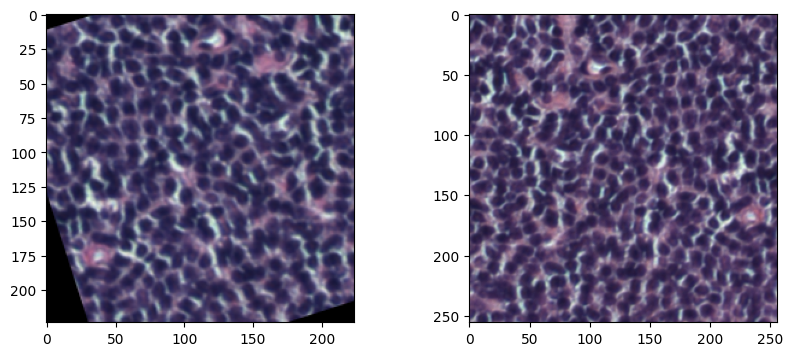

In [ ]:
(img, label, img_old)=dataset["train"][7]
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].imshow(np.moveaxis(img.numpy(),0,-1))
ax[1].imshow(img_old)

print(label)

In [ ]:
optim = torch.optim.Adam(model.parameters())
nclasses = dataset["train"].classsizes.shape[0]
class_weight=dataset["train"].classsizes
class_weight = torch.from_numpy(1-class_weight/class_weight.sum()).type('torch.FloatTensor').to(device)

print(class_weight)
criterion = nn.CrossEntropyLoss(weight = class_weight)

tensor([0.6900, 0.6300, 0.6800], device='cuda:0')


In [ ]:
writer = SummaryWriter()
best_loss_on_test = np.Infinity

start_time = time.time()
for epoch in range(num_epochs):
    all_acc = {key: 0 for key in phases}
    all_loss = {key: torch.zeros(0).to(device) for key in phases}
    cmatrix = {key: np.zeros((num_classes,num_classes)) for key in phases}

    for phase in phases:

        if phase == 'train':
            model.train()
        else:
            model.eval()

        for ii , (X, label, img_orig) in enumerate(dataLoader[phase]):
            X = X.to(device)
            label = label.type('torch.LongTensor').to(device)

            with torch.set_grad_enabled(phase == 'train'):
                prediction = model(X)
                loss = criterion(prediction, label)

                # Calculate accuracy for this batch
                _, preds = torch.max(prediction, 1)
                all_acc[phase] += torch.sum(preds == label.data)


                if phase=="train":
                    optim.zero_grad()
                    loss.backward()
                    optim.step()
                    train_loss = loss


                all_loss[phase]=torch.cat((all_loss[phase],loss.detach().view(1,-1)))

                if phase in validation_phases:
                    p=prediction.detach().cpu().numpy()
                    cpredflat=np.argmax(p,axis=1).flatten()
                    yflat=label.cpu().numpy().flatten()

                    cmatrix[phase]=cmatrix[phase]+confusion_matrix(yflat,cpredflat, labels=range(nclasses))

        # Calculate epoch accuracy
        all_acc[phase] = all_acc[phase].item() / len(dataset[phase])
        all_loss[phase] = all_loss[phase].cpu().numpy().mean()

        writer.add_scalar(f'{phase}/loss', all_loss[phase], epoch)
        # Log accuracy to TensorBoard
        writer.add_scalar(f'{phase}/accuracy', all_acc[phase], epoch)
        if phase in validation_phases:
            #writer.add_scalar(f'{phase}/acc', all_acc[phase], epoch)
            for r in range(nclasses):
                for c in range(nclasses):
                    writer.add_scalar(f'{phase}/{r}{c}', cmatrix[phase][r][c],epoch)

    print('%s ([%d/%d] %d%%), train loss: %.4f test loss: %.4f train acc: %.4f test acc: %.4f' % (timeSince(start_time, (epoch+1) / num_epochs),
                                                 epoch+1, num_epochs ,(epoch+1) / num_epochs * 100, all_loss["train"], all_loss["val"], all_acc["train"], all_acc["val"]),end="")    #changed here

    if all_loss["val"] < best_loss_on_test:
        best_loss_on_test = all_loss["val"]
        print("  **")
        state = {'epoch': epoch + 1,
         'model_dict': model.state_dict(),
         'optim_dict': optim.state_dict(),
         'best_loss_on_test': all_loss,
         'in_channels': in_channels,
         'growth_rate':growth_rate,
         'block_config':block_config,
         'num_init_features':num_init_features,
         'bn_size':bn_size,
         'drop_rate':drop_rate,
         'num_classes':num_classes}


        torch.save(state, f"/content/drive/MyDrive/lymphoma.tar/{dataname}_densenet_best_model.pth")
    else:
        print("")

0m 40s (- 66m 25s) ([1/100] 1%), train loss: 0.6907 test loss: 1.6178 train acc: 0.6907 test acc: 0.4483  **


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


1m 11s (- 58m 1s) ([2/100] 2%), train loss: 0.4152 test loss: 1.0524 train acc: 0.8417 test acc: 0.5717  **


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


1m 41s (- 54m 46s) ([3/100] 3%), train loss: 0.2631 test loss: 1.4289 train acc: 0.9063 test acc: 0.5400


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


2m 12s (- 52m 48s) ([4/100] 4%), train loss: 0.2632 test loss: 1.1973 train acc: 0.8977 test acc: 0.5917


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


2m 44s (- 52m 3s) ([5/100] 5%), train loss: 0.1987 test loss: 1.2857 train acc: 0.9207 test acc: 0.5700


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


3m 14s (- 50m 54s) ([6/100] 6%), train loss: 0.1845 test loss: 1.6809 train acc: 0.9340 test acc: 0.6167


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


3m 44s (- 49m 40s) ([7/100] 7%), train loss: 0.1880 test loss: 1.0544 train acc: 0.9250 test acc: 0.6417


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


4m 14s (- 48m 51s) ([8/100] 8%), train loss: 0.1642 test loss: 1.4482 train acc: 0.9333 test acc: 0.5767


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


4m 45s (- 48m 7s) ([9/100] 9%), train loss: 0.1462 test loss: 1.3579 train acc: 0.9440 test acc: 0.6250


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


5m 18s (- 47m 41s) ([10/100] 10%), train loss: 0.1281 test loss: 1.0186 train acc: 0.9527 test acc: 0.7367  **


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


5m 48s (- 47m 0s) ([11/100] 11%), train loss: 0.1405 test loss: 1.4827 train acc: 0.9460 test acc: 0.6050


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


6m 18s (- 46m 13s) ([12/100] 12%), train loss: 0.1402 test loss: 2.8541 train acc: 0.9497 test acc: 0.4267


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


6m 49s (- 45m 41s) ([13/100] 13%), train loss: 0.1338 test loss: 1.0228 train acc: 0.9497 test acc: 0.6933


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


7m 19s (- 45m 0s) ([14/100] 14%), train loss: 0.1108 test loss: 0.8953 train acc: 0.9597 test acc: 0.7200  **


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


7m 51s (- 44m 32s) ([15/100] 15%), train loss: 0.0821 test loss: 2.2065 train acc: 0.9730 test acc: 0.5950


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


8m 21s (- 43m 53s) ([16/100] 16%), train loss: 0.0981 test loss: 1.1814 train acc: 0.9643 test acc: 0.7000


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


8m 52s (- 43m 17s) ([17/100] 17%), train loss: 0.0824 test loss: 1.2062 train acc: 0.9707 test acc: 0.6717


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


9m 23s (- 42m 45s) ([18/100] 18%), train loss: 0.0683 test loss: 1.1046 train acc: 0.9713 test acc: 0.7633


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


9m 55s (- 42m 18s) ([19/100] 19%), train loss: 0.0774 test loss: 2.5190 train acc: 0.9733 test acc: 0.5650


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


10m 25s (- 41m 43s) ([20/100] 20%), train loss: 0.0936 test loss: 2.2680 train acc: 0.9643 test acc: 0.5533


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


10m 55s (- 41m 6s) ([21/100] 21%), train loss: 0.1081 test loss: 2.2880 train acc: 0.9617 test acc: 0.6100


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


11m 26s (- 40m 32s) ([22/100] 22%), train loss: 0.1135 test loss: 2.0749 train acc: 0.9593 test acc: 0.5583


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


11m 56s (- 39m 58s) ([23/100] 23%), train loss: 0.0955 test loss: 2.1675 train acc: 0.9643 test acc: 0.6883


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


12m 28s (- 39m 30s) ([24/100] 24%), train loss: 0.0943 test loss: 1.4533 train acc: 0.9643 test acc: 0.5250


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


12m 59s (- 38m 56s) ([25/100] 25%), train loss: 0.0672 test loss: 1.0028 train acc: 0.9753 test acc: 0.7467


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


13m 29s (- 38m 23s) ([26/100] 26%), train loss: 0.0626 test loss: 1.0079 train acc: 0.9770 test acc: 0.7583


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


13m 59s (- 37m 49s) ([27/100] 27%), train loss: 0.0709 test loss: 2.2874 train acc: 0.9740 test acc: 0.4950


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


14m 29s (- 37m 17s) ([28/100] 28%), train loss: 0.0579 test loss: 1.4293 train acc: 0.9793 test acc: 0.6600


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


15m 1s (- 36m 47s) ([29/100] 28%), train loss: 0.0656 test loss: 1.4198 train acc: 0.9763 test acc: 0.6550


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


15m 31s (- 36m 13s) ([30/100] 30%), train loss: 0.0593 test loss: 1.7263 train acc: 0.9770 test acc: 0.6383


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


16m 2s (- 35m 41s) ([31/100] 31%), train loss: 0.0733 test loss: 1.3907 train acc: 0.9737 test acc: 0.6850


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


16m 32s (- 35m 9s) ([32/100] 32%), train loss: 0.0660 test loss: 2.3303 train acc: 0.9747 test acc: 0.6417


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


17m 4s (- 34m 39s) ([33/100] 33%), train loss: 0.0749 test loss: 1.0282 train acc: 0.9733 test acc: 0.6367


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


17m 35s (- 34m 8s) ([34/100] 34%), train loss: 0.0565 test loss: 0.8155 train acc: 0.9797 test acc: 0.8350  **


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


18m 4s (- 33m 34s) ([35/100] 35%), train loss: 0.0809 test loss: 1.6824 train acc: 0.9707 test acc: 0.6267


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


18m 34s (- 33m 1s) ([36/100] 36%), train loss: 0.0764 test loss: 1.7920 train acc: 0.9753 test acc: 0.7167


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


19m 5s (- 32m 30s) ([37/100] 37%), train loss: 0.0815 test loss: 1.8297 train acc: 0.9733 test acc: 0.5250


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


19m 36s (- 31m 59s) ([38/100] 38%), train loss: 0.0778 test loss: 2.3850 train acc: 0.9740 test acc: 0.6083


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


20m 7s (- 31m 28s) ([39/100] 39%), train loss: 0.0443 test loss: 0.8846 train acc: 0.9850 test acc: 0.7717


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


20m 37s (- 30m 56s) ([40/100] 40%), train loss: 0.0310 test loss: 0.7607 train acc: 0.9883 test acc: 0.8333  **


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


21m 8s (- 30m 25s) ([41/100] 41%), train loss: 0.0389 test loss: 0.6969 train acc: 0.9860 test acc: 0.8617  **


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


21m 39s (- 29m 54s) ([42/100] 42%), train loss: 0.0511 test loss: 2.2697 train acc: 0.9837 test acc: 0.5500


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


22m 11s (- 29m 24s) ([43/100] 43%), train loss: 0.0583 test loss: 1.6272 train acc: 0.9813 test acc: 0.7033


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


22m 41s (- 28m 52s) ([44/100] 44%), train loss: 0.0481 test loss: 1.1622 train acc: 0.9813 test acc: 0.7433


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


23m 11s (- 28m 20s) ([45/100] 45%), train loss: 0.0473 test loss: 1.2525 train acc: 0.9817 test acc: 0.7567


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


23m 42s (- 27m 50s) ([46/100] 46%), train loss: 0.0895 test loss: 2.1882 train acc: 0.9727 test acc: 0.6417


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


24m 15s (- 27m 20s) ([47/100] 47%), train loss: 0.0799 test loss: 1.0125 train acc: 0.9700 test acc: 0.7067


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


24m 46s (- 26m 49s) ([48/100] 48%), train loss: 0.0470 test loss: 0.9322 train acc: 0.9833 test acc: 0.7517


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


25m 17s (- 26m 19s) ([49/100] 49%), train loss: 0.0352 test loss: 1.4027 train acc: 0.9880 test acc: 0.7400


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


25m 48s (- 25m 48s) ([50/100] 50%), train loss: 0.0361 test loss: 0.9973 train acc: 0.9873 test acc: 0.7950


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


26m 20s (- 25m 18s) ([51/100] 51%), train loss: 0.0455 test loss: 0.7853 train acc: 0.9853 test acc: 0.7650


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


26m 50s (- 24m 46s) ([52/100] 52%), train loss: 0.0346 test loss: 3.0343 train acc: 0.9883 test acc: 0.5283


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


27m 24s (- 24m 18s) ([53/100] 53%), train loss: 0.0276 test loss: 0.9071 train acc: 0.9910 test acc: 0.7600


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


27m 57s (- 23m 48s) ([54/100] 54%), train loss: 0.0384 test loss: 1.3831 train acc: 0.9863 test acc: 0.7983


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


28m 27s (- 23m 16s) ([55/100] 55%), train loss: 0.0511 test loss: 4.5410 train acc: 0.9807 test acc: 0.5750


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


28m 57s (- 22m 44s) ([56/100] 56%), train loss: 0.0520 test loss: 1.3846 train acc: 0.9813 test acc: 0.7033


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


29m 28s (- 22m 14s) ([57/100] 56%), train loss: 0.0336 test loss: 2.5431 train acc: 0.9903 test acc: 0.6167


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


30m 0s (- 21m 43s) ([58/100] 57%), train loss: 0.0307 test loss: 0.5463 train acc: 0.9887 test acc: 0.8717  **


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


30m 31s (- 21m 12s) ([59/100] 59%), train loss: 0.0255 test loss: 0.6532 train acc: 0.9933 test acc: 0.8283


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


31m 2s (- 20m 41s) ([60/100] 60%), train loss: 0.0177 test loss: 0.9211 train acc: 0.9933 test acc: 0.8050


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


31m 33s (- 20m 10s) ([61/100] 61%), train loss: 0.0214 test loss: 2.0706 train acc: 0.9943 test acc: 0.6650


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


32m 5s (- 19m 40s) ([62/100] 62%), train loss: 0.0238 test loss: 1.5215 train acc: 0.9933 test acc: 0.7283


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


32m 37s (- 19m 9s) ([63/100] 63%), train loss: 0.0296 test loss: 2.0286 train acc: 0.9890 test acc: 0.6767


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


33m 8s (- 18m 38s) ([64/100] 64%), train loss: 0.0410 test loss: 2.0171 train acc: 0.9873 test acc: 0.5983


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


33m 39s (- 18m 7s) ([65/100] 65%), train loss: 0.0242 test loss: 1.1017 train acc: 0.9943 test acc: 0.7433


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


34m 12s (- 17m 37s) ([66/100] 66%), train loss: 0.0420 test loss: 2.2473 train acc: 0.9860 test acc: 0.6333


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


34m 43s (- 17m 6s) ([67/100] 67%), train loss: 0.0503 test loss: 2.5054 train acc: 0.9813 test acc: 0.5950


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


35m 14s (- 16m 35s) ([68/100] 68%), train loss: 0.0460 test loss: 1.7315 train acc: 0.9837 test acc: 0.6250


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


35m 45s (- 16m 3s) ([69/100] 69%), train loss: 0.0517 test loss: 1.6273 train acc: 0.9827 test acc: 0.6500


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


36m 17s (- 15m 33s) ([70/100] 70%), train loss: 0.0325 test loss: 1.6724 train acc: 0.9893 test acc: 0.6400


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


36m 47s (- 15m 1s) ([71/100] 71%), train loss: 0.0487 test loss: 1.3759 train acc: 0.9840 test acc: 0.7500


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


37m 19s (- 14m 30s) ([72/100] 72%), train loss: 0.0342 test loss: 1.2973 train acc: 0.9877 test acc: 0.7267


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


37m 50s (- 13m 59s) ([73/100] 73%), train loss: 0.0317 test loss: 2.0063 train acc: 0.9890 test acc: 0.6700


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


38m 22s (- 13m 28s) ([74/100] 74%), train loss: 0.0435 test loss: 2.4031 train acc: 0.9843 test acc: 0.7000


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


38m 52s (- 12m 57s) ([75/100] 75%), train loss: 0.0351 test loss: 1.9908 train acc: 0.9903 test acc: 0.6417


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


39m 23s (- 12m 26s) ([76/100] 76%), train loss: 0.0369 test loss: 1.7305 train acc: 0.9847 test acc: 0.6967


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


39m 54s (- 11m 55s) ([77/100] 77%), train loss: 0.0341 test loss: 2.5816 train acc: 0.9877 test acc: 0.5617


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


40m 27s (- 11m 24s) ([78/100] 78%), train loss: 0.0236 test loss: 1.8257 train acc: 0.9917 test acc: 0.7167


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


40m 57s (- 10m 53s) ([79/100] 79%), train loss: 0.0441 test loss: 2.2944 train acc: 0.9850 test acc: 0.6217


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


41m 28s (- 10m 21s) ([80/100] 80%), train loss: 0.0352 test loss: 3.5257 train acc: 0.9873 test acc: 0.5433


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


41m 58s (- 9m 50s) ([81/100] 81%), train loss: 0.0269 test loss: 1.6825 train acc: 0.9913 test acc: 0.6900


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


42m 30s (- 9m 19s) ([82/100] 82%), train loss: 0.0457 test loss: 2.2206 train acc: 0.9850 test acc: 0.7133


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


43m 1s (- 8m 48s) ([83/100] 83%), train loss: 0.0255 test loss: 1.2559 train acc: 0.9917 test acc: 0.7800


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


43m 32s (- 8m 17s) ([84/100] 84%), train loss: 0.0174 test loss: 1.4247 train acc: 0.9937 test acc: 0.7550


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


44m 3s (- 7m 46s) ([85/100] 85%), train loss: 0.0263 test loss: 1.6322 train acc: 0.9920 test acc: 0.6617


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


44m 36s (- 7m 15s) ([86/100] 86%), train loss: 0.0554 test loss: 0.9854 train acc: 0.9850 test acc: 0.8067


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


45m 6s (- 6m 44s) ([87/100] 87%), train loss: 0.0348 test loss: 1.3587 train acc: 0.9893 test acc: 0.7017


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


45m 36s (- 6m 13s) ([88/100] 88%), train loss: 0.0222 test loss: 1.5779 train acc: 0.9927 test acc: 0.7250


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


46m 7s (- 5m 42s) ([89/100] 89%), train loss: 0.0207 test loss: 0.8100 train acc: 0.9937 test acc: 0.8433


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


46m 39s (- 5m 11s) ([90/100] 90%), train loss: 0.0283 test loss: 1.4855 train acc: 0.9897 test acc: 0.6367


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


47m 10s (- 4m 39s) ([91/100] 91%), train loss: 0.0316 test loss: 1.0102 train acc: 0.9910 test acc: 0.7917


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


47m 40s (- 4m 8s) ([92/100] 92%), train loss: 0.0169 test loss: 1.2393 train acc: 0.9943 test acc: 0.7883


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


48m 11s (- 3m 37s) ([93/100] 93%), train loss: 0.0277 test loss: 2.0973 train acc: 0.9907 test acc: 0.6467


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


48m 43s (- 3m 6s) ([94/100] 94%), train loss: 0.0283 test loss: 0.4796 train acc: 0.9897 test acc: 0.8583  **


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


49m 14s (- 2m 35s) ([95/100] 95%), train loss: 0.0245 test loss: 1.4465 train acc: 0.9907 test acc: 0.6917


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


49m 45s (- 2m 4s) ([96/100] 96%), train loss: 0.0185 test loss: 2.3373 train acc: 0.9940 test acc: 0.7267


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


50m 16s (- 1m 33s) ([97/100] 97%), train loss: 0.0279 test loss: 1.7327 train acc: 0.9903 test acc: 0.7050


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


50m 48s (- 1m 2s) ([98/100] 98%), train loss: 0.0324 test loss: 0.8589 train acc: 0.9900 test acc: 0.8267


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


51m 19s (- 0m 31s) ([99/100] 99%), train loss: 0.0305 test loss: 2.0788 train acc: 0.9907 test acc: 0.6433


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


51m 49s (- -1m 59s) ([100/100] 100%), train loss: 0.0444 test loss: 6.6718 train acc: 0.9853 test acc: 0.4200
